# Import Modules #

In [2]:
import os
import pickle
import numpy as np
from tqdm.notebook import tqdm

from tensorflow.keras.applications.vgg16 import VGG16, preprocess_input
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Model
from tensorflow.keras.utils import to_categorical, plot_model
from tensorflow.keras.layers import Input, Dense, LSTM, Embedding, Dropout, add
from nltk.translate.bleu_score import corpus_bleu
from PIL import Image
import matplotlib.pyplot as plt
import re

2025-07-27 12:17:01.821131: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1753618621.975534  438744 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1753618622.023011  438744 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [3]:
BASE_DIR = '/kaggle/input/flickr8k'
WORKING_DIR = '/kaggle/working'

# Extract Image Features #

In [4]:
# VGG16 Model
model = VGG16()
model = Model(inputs = model.inputs, outputs = model.layers[-2].output)
print(model.summary())

I0000 00:00:1753618630.060993  438744 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13942 MB memory:  -> device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5
I0000 00:00:1753618630.061780  438744 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 13942 MB memory:  -> device: 1, name: Tesla T4, pci bus id: 0000:00:05.0, compute capability: 7.5


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 224, 224, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 224, 224, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 112, 112, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 112, 112, 128)  │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 112, 112, 128)  │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 56, 56, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 56, 56, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 28, 28, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 28, 28, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 14, 14, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 7, 7, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 25088)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ fc1 (Dense)                     │ (None, 4096)           │   102,764,544 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ fc2 (Dense)                     │ (None, 4096)           │    16,781,312 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 134,260,544 (512.16 MB)

 Trainable params: 134,260,544 (512.16 MB)

 Non-trainable params: 0 (0.00 B)

None


In [5]:
# Extract Features from Image
features = {}
directory = os.path.join(BASE_DIR, 'Images')

for img_name in tqdm(os.listdir(directory)):
    img_path = directory + '/' + img_name
    image = load_img(img_path, target_size = (224, 224))
    # Converting Image Pixels to Numpy Array
    image = img_to_array(image)
    # Reshaping Data for Model
    image = image.reshape((1, image.shape[0], image.shape[1], image.shape[2]))
    # PreProcess Image for VGG
    image = preprocess_input(image)
    # Extraction
    feature = model.predict(image, verbose=0)
    image_id = img_name.split('.')[0]
    # Store Feature
    features[image_id] = feature

  0%|          | 0/8091 [00:00<?, ?it/s]

/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor']
Received: inputs=Tensor(shape=(1, 224, 224, 3))
  warnings.warn(msg)
I0000 00:00:1753618635.346174  438780 service.cc:148] XLA service 0x7ac320003d10 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1753618635.346929  438780 service.cc:156]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1753618635.346949  438780 service.cc:156]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5
I0000 00:00:1753618635.480305  438780 cuda_dnn.cc:529] Loaded cuDNN version 90300
I0000 00:00:1753618637.908780  438780 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


In [6]:
# Store Features in Pickle
pickle.dump(features, open(os.path.join(WORKING_DIR, 'features.pkl'),'wb'))

In [7]:
# Load Features from Pickle
with open(os.path.join(WORKING_DIR, 'features.pkl'),'rb') as f:
    features = pickle.load(f)

# Loading Captions Data #

In [8]:
with open(os.path.join(BASE_DIR, 'captions.txt'),'r') as f:
    next(f)
    captions_doc = f.read()

In [9]:
# Create Mapping of Images to Captions
mapping = {}

for line in tqdm(captions_doc.split('\n')):
    tokens = line.split(',')
    if len(line) < 2:
        continue
    image_id, caption = tokens[0], tokens[1:]
    # Removing Extensions from Image ID
    image_id = image_id.split('.')[0]
    caption = " ".join(caption)
    # Create List if needed 
    if image_id not in mapping:
        mapping[image_id] = []
    mapping[image_id].append(caption)

  0%|          | 0/40456 [00:00<?, ?it/s]

In [10]:
len(mapping)

8091

# PreProcess Text Data #

In [11]:
def clean(mapping):
    for key, captions in mapping.items():
        for i in range(len(captions)):
            # Take one caption at a time
            caption = captions[i]
            # Convert to lowercase
            caption = caption.lower()
            # Remove digits and special characters using regex
            caption = re.sub(r'[^a-zA-Z]', ' ', caption)
            # Remove extra whitespace
            caption = re.sub(r'\s+', ' ', caption).strip()
            # Remove short words and add start/end tokens
            caption = 'startseq ' + " ".join([word for word in caption.split() if len(word) > 1]) + ' endseq'
            # Update the caption
            captions[i] = caption

In [12]:
# Before PreProcess of Text
mapping['1000268201_693b08cb0e']

['A child in a pink dress is climbing up a set of stairs in an entry way .',
 'A girl going into a wooden building .',
 'A little girl climbing into a wooden playhouse .',
 'A little girl climbing the stairs to her playhouse .',
 'A little girl in a pink dress going into a wooden cabin .']

In [13]:
# PreProcess the Text
clean(mapping)

In [14]:
# After PreProcess of Text
mapping['1000268201_693b08cb0e']

['startseq child in pink dress is climbing up set of stairs in an entry way endseq',
 'startseq girl going into wooden building endseq',
 'startseq little girl climbing into wooden playhouse endseq',
 'startseq little girl climbing the stairs to her playhouse endseq',
 'startseq little girl in pink dress going into wooden cabin endseq']

In [15]:
all_captions = []
for key in mapping:
    for caption in mapping[key]:
        all_captions.append(caption)

In [16]:
len(all_captions)

40455

In [17]:
all_captions[:10]

['startseq child in pink dress is climbing up set of stairs in an entry way endseq',
 'startseq girl going into wooden building endseq',
 'startseq little girl climbing into wooden playhouse endseq',
 'startseq little girl climbing the stairs to her playhouse endseq',
 'startseq little girl in pink dress going into wooden cabin endseq',
 'startseq black dog and spotted dog are fighting endseq',
 'startseq black dog and tri colored dog playing with each other on the road endseq',
 'startseq black dog and white dog with brown spots are staring at each other in the street endseq',
 'startseq two dogs of different breeds looking at each other on the road endseq',
 'startseq two dogs on pavement moving toward each other endseq']

In [18]:
# Tokenize the Text
tokenizer = Tokenizer()
tokenizer.fit_on_texts(all_captions)
vocab_size = len(tokenizer.word_index) + 1

In [19]:
vocab_size

8427

In [20]:
# Maximum Length of the Caption available
max_length = max(len(caption.split())for caption in all_captions)
max_length

35

# Train Test Splitting #

In [21]:
image_ids = list(mapping.keys())
split = int(len(image_ids) * 0.90)
train = image_ids[:split]
test = image_ids[split:]

In [22]:
# Create Data Generator to get data in Batch
def data_generator(data_keys, mapping, features, tokenizer, max_length, vocab_size, batch_size):
    X1, X2, y = list(), list(), list()
    n = 0
    while 1:
        for key in data_keys:
            n += 1
            captions = mapping[key]
            # Processing each Caption
            for caption in captions:
                # Encoding the Sequence
                seq = tokenizer.texts_to_sequences([caption])[0]
                for i in range(1, len(seq)):
                    # split into input and output pairs
                    in_seq, out_seq = seq[:i], seq[i]
                    # Pad Input Sequence
                    in_seq = pad_sequences([in_seq], maxlen=max_length, padding='post')[0]
                    # Encode Output Sequence
                    out_seq = to_categorical([out_seq], 	num_classes=vocab_size)[0]
                    # Store the Sequences
                    X1.append(features[key][0])
                    X2.append(in_seq)
                    y.append(out_seq)
            if n == batch_size:
                X1, X2, y = np.array(X1), np.array(X2), np.array(y)
                yield {"image": X1, "text": X2}, y
                X1, X2, y = list(), list(), list()
                n = 0

# Model Creation #

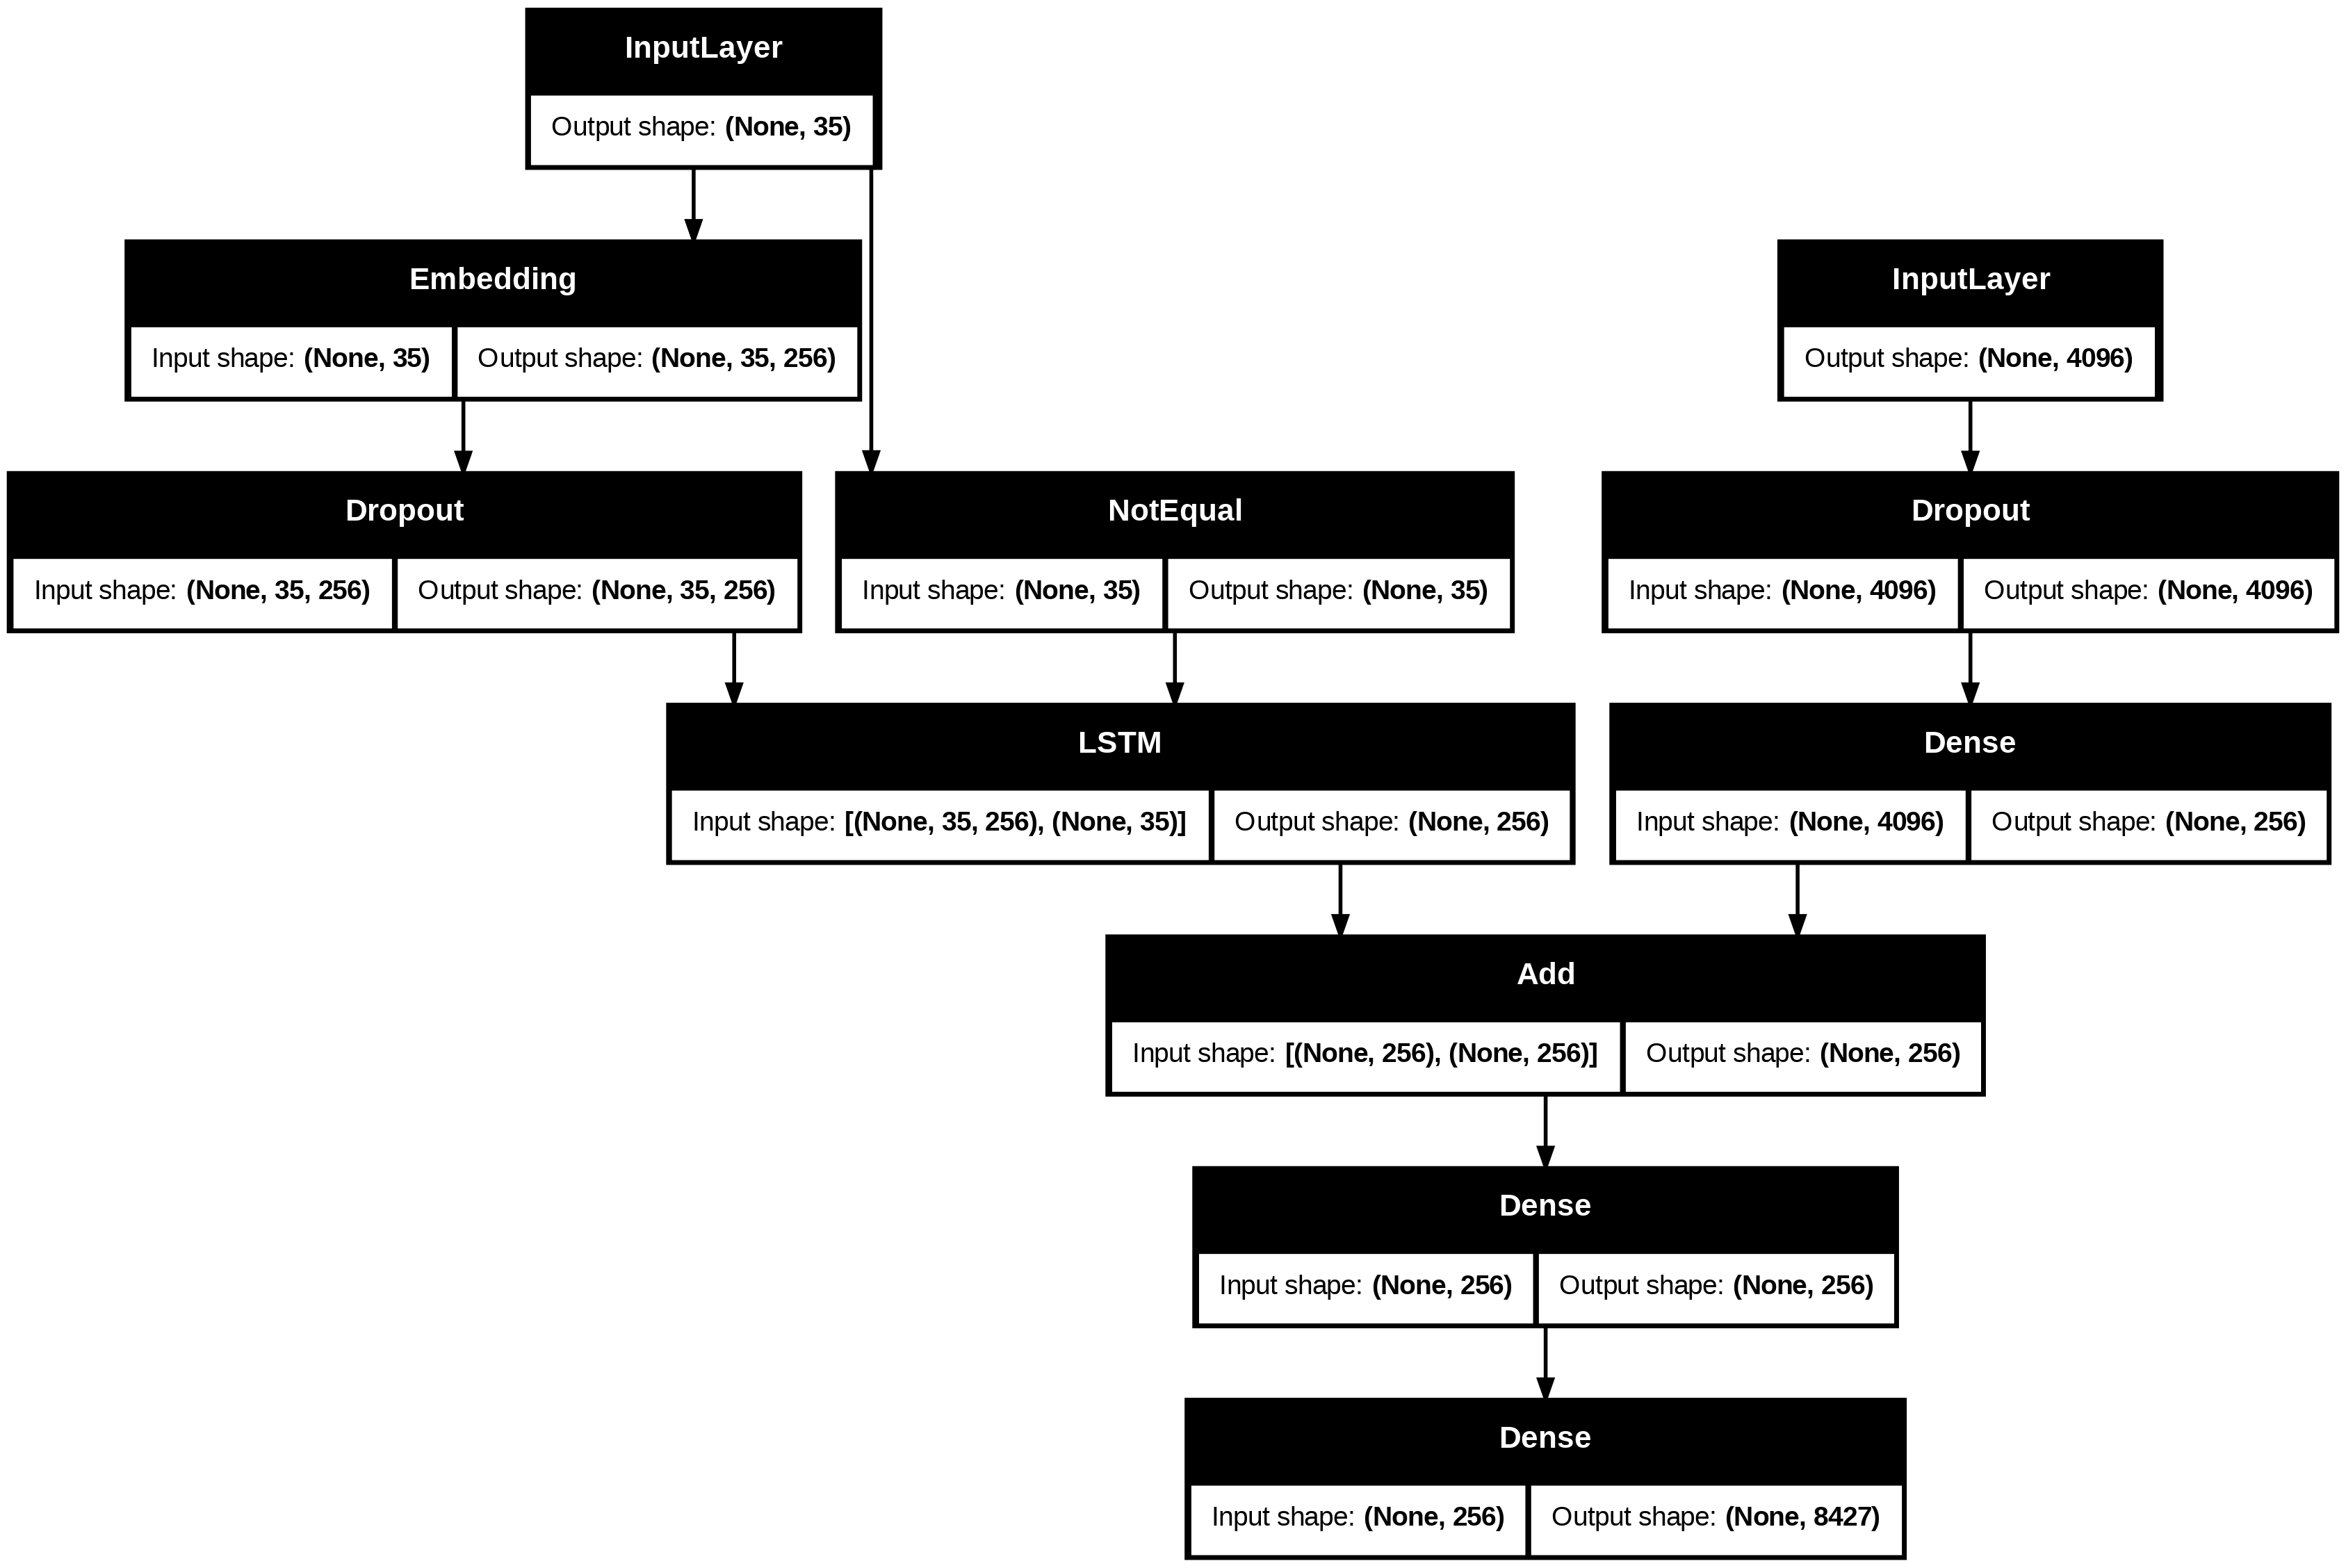

In [23]:
# Encoder Model
# Image Feature Model
inputs1 = Input(shape=(4096,),name = "image")
fe1 = Dropout(0.4)(inputs1)
fe2 = Dense(256, activation = 'relu')(fe1)
# Sequence Feature Layers
inputs2 = Input(shape=(max_length,),name = "text")
se1 = Embedding(vocab_size, 256, mask_zero = True)(inputs2)
se2 = Dropout(0.4)(se1)
se3 = LSTM(256)(se2)

# Decoder Model
decoder1 = add([fe2, se3])
decoder2 = Dense(256, activation = 'relu')(decoder1)
outputs = Dense(vocab_size, activation = 'softmax')(decoder2)

model = Model(inputs = [inputs1, inputs2], outputs = outputs)
model.compile(loss = 'categorical_crossentropy', optimizer = 'adam')

# Plotting the Model
plot_model(model, show_shapes = True)

In [24]:
# Train the Model
epochs = 20
batch_size = 64
steps = len(train) // batch_size

for i in range(epochs):
    generator = data_generator(train, mapping, features, tokenizer, max_length, vocab_size, batch_size)
    model.fit(generator, epochs = 1, steps_per_epoch = steps, verbose = 1)

113/113 ━━━━━━━━━━━━━━━━━━━━ 60s 493ms/step - loss: 6.1578
113/113 ━━━━━━━━━━━━━━━━━━━━ 55s 489ms/step - loss: 4.4155
113/113 ━━━━━━━━━━━━━━━━━━━━ 54s 479ms/step - loss: 3.7798
113/113 ━━━━━━━━━━━━━━━━━━━━ 54s 479ms/step - loss: 3.4735
113/113 ━━━━━━━━━━━━━━━━━━━━ 54s 482ms/step - loss: 3.2551
113/113 ━━━━━━━━━━━━━━━━━━━━ 54s 477ms/step - loss: 3.0940
113/113 ━━━━━━━━━━━━━━━━━━━━ 54s 480ms/step - loss: 2.9621
113/113 ━━━━━━━━━━━━━━━━━━━━ 56s 493ms/step - loss: 2.8592
113/113 ━━━━━━━━━━━━━━━━━━━━ 54s 482ms/step - loss: 2.7776
113/113 ━━━━━━━━━━━━━━━━━━━━ 54s 480ms/step - loss: 2.7028
113/113 ━━━━━━━━━━━━━━━━━━━━ 54s 480ms/step - loss: 2.6363
113/113 ━━━━━━━━━━━━━━━━━━━━ 54s 480ms/step - loss: 2.5733
113/113 ━━━━━━━━━━━━━━━━━━━━ 54s 479ms/step - loss: 2.5204
113/113 ━━━━━━━━━━━━━━━━━━━━ 54s 480ms/step - loss: 2.4669
113/113 ━━━━━━━━━━━━━━━━━━━━ 54s 479ms/step - loss: 2.4206
113/113 ━━━━━━━━━━━━━━━━━━━━ 55s 484ms/step - loss: 2.3782
113/113 ━━━━━━━━━━━━━━━━━━━━ 55s 485ms/step - loss: 2.34

In [25]:
# Saving the Model
model.save(WORKING_DIR + '/best_model.h5')

# Generate Captions from image #

In [26]:
def idx_to_word(integer, tokenizer):
    for word, index in tokenizer.word_index.items():
        if index == integer:
            return word
    return None

In [29]:
# Generate Caption for an Image
def predict_caption(model, image, tokenizer, max_length):
    in_text = 'startseq'
    for i in range(max_length):
        # Encode Input Sequence
        sequence = tokenizer.texts_to_sequences([in_text])[0]
        # Pad the Sequence
        sequence = pad_sequences([sequence], maxlen=max_length, padding='post')
        # Predict Next Word
        yhat = model.predict([image, sequence], verbose=0)
        # Get Index with High Probability
        yhat = np.argmax(yhat)
        # Convert Index to Word
        word = idx_to_word(yhat, tokenizer)
        if word is None:
            break
        # Append Word as Input for Generating Next Word
        in_text += " " + word
        if word == 'endseq':
            break
    return in_text

In [30]:
from nltk.translate.bleu_score import corpus_bleu
# Validate with Test Data
actual, predicted = list(), list()

for key in tqdm(test):
    # Get Actual Caption
    captions = mapping[key]
    # Predict the caption for image
    y_pred = predict_caption(model, features[key], tokenizer, max_length)
    actual_captions = [caption.split() for caption in captions]
    y_pred = y_pred.split()
    # append to the list
    actual.append(actual_captions)
    predicted.append(y_pred)
    
# calcuate BLEU score
print("BLEU-1: %f" % corpus_bleu(actual, predicted, weights=(1.0, 0, 0, 0)))
print("BLEU-2: %f" % corpus_bleu(actual, predicted, weights=(0.5, 0.5, 0, 0)))

  0%|          | 0/810 [00:00<?, ?it/s]

BLEU-1: 0.533098
BLEU-2: 0.307498


# Visualise the Result #

In [31]:
def generate_caption(image_name):
    image_id = image_name.split('.')[0]
    img_path = os.path.join(BASE_DIR, "Images", image_name)
    image = Image.open(img_path)
    captions = mapping[image_id]
    print('---------------------Actual---------------------')
    for caption in captions:
        print(caption)
    # predict the caption
    y_pred = predict_caption(model, features[image_id], tokenizer, max_length)
    print('--------------------Predicted--------------------')
    print(y_pred)
    plt.imshow(image)

---------------------Actual---------------------
startseq little girl covered in paint sits in front of painted rainbow with her hands in bowl endseq
startseq little girl is sitting in front of large painted rainbow endseq
startseq small girl in the grass plays with fingerpaints in front of white canvas with rainbow on it endseq
startseq there is girl with pigtails sitting in front of rainbow painting endseq
startseq young girl with pigtails painting outside in the grass endseq
--------------------Predicted--------------------
startseq little girl in pigtails is sitting in the grass with fingerpaints in her head endseq


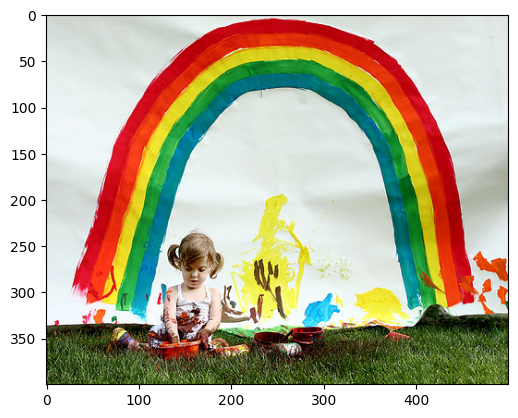

In [32]:
generate_caption("1002674143_1b742ab4b8.jpg")

---------------------Actual---------------------
startseq man drilling hole in the ice endseq
startseq man is drilling through the frozen ice of pond endseq
startseq person in the snow drilling hole in the ice endseq
startseq person standing on frozen lake endseq
startseq two men are ice fishing endseq
--------------------Predicted--------------------
startseq two skateboarders play in the water endseq


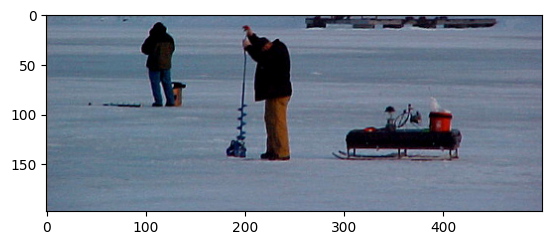

In [33]:
generate_caption('102351840_323e3de834.jpg')